# 决策树

优点：计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据。\
缺点：可能会产生过度匹配问题。\
适用数据类型：数值型和标称型

### 决策树的一般流程

收集数据：可以适用任何方法。\
准备数据：树构造算法只适用于标称型数据，因此数值型数据必须离散化。\
分析数据：可以使用任何方法，构造树完成之后，我们应该检查图形是否符合预期。\
训练算法：构造树的数据结构。\
测试算法：使用经验树计算错误率。\
使用算法：更好地理解数据内在含义。

简单的🐟鉴定数据集

| 物种 | 不浮出水面是否可以生存 | 是否有脚蹼 | 属于鱼类 |
| - | :--: | :--: | :--: | 
| 1 |是                                          |是                    |是                 |
| 2 |是                                          |是                    |是                 |
| 3 |是                                          |否                    |否                 |
| 4 |否                                          |是                    |否                 |
| 5 |否                                          |是                    |否                 |

In [ ]:
from trees import createDataSet,calcShannonEnt

In [3]:
myDat, labels=createDataSet()
print(myDat)
calcShannonEnt(myDat)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


0.9709505944546686

熵越高，则混合的数据也越多，这里增加第三个名为maybe的分类，测试熵的变化：

In [4]:
myDat[0][-1]='maybe'
print(myDat)
calcShannonEnt(myDat)

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


1.3709505944546687

得到熵以后，我们可以按照获取最大信息增益的方法划分数据集

### 划分数据集

In [5]:
def splitDataSet(dataSet, axis, value):#待划分的数据集，划分数据集的特征，需要返回的特征的值
    retDataSet = []#不修改原始数据，创建一个新列表对象
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])#注意extend和attend用法区别
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [6]:
myDat1, labels1=createDataSet()
print(myDat1)
print(splitDataSet(myDat1,0,1))#按照第一个特征划分，特征值为1
print(splitDataSet(myDat1,0,0))#按照第一个特征划分，特征值为0

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
[[1, 'yes'], [1, 'yes'], [0, 'no']]
[[1, 'no'], [1, 'no']]


选择最好的数据集划分方式

In [7]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet]#create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
    return bestFeature                      #returns an integer

In [8]:
chooseBestFeatureToSplit(myDat1)

0

代码结果表示第0个特征是最好的用于划分数据集的特征

如果数据集已经处理了所有的属性，但是类标签依然不唯一，此时需要用多数表决法决定叶子节点分类

In [9]:
def createTree(dataSet, labels):#创建树
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]#stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

In [10]:
myTree  = createTree(myDat1, labels1)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

使用matplotlib来绘制树形图

In [13]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

In [14]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree)[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else: numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree)[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else: thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def retrieveTree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                   {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree)[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            plotTree(secondDict[key], cntrPt, str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

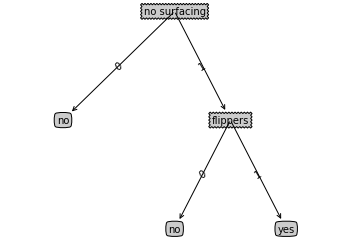

In [15]:
retrieveTree(0)
createPlot(myTree)

### 使用决策树的分类函数

In [16]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree)[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict):
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

In [19]:
myTree =retrieveTree(0)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [20]:
classify(myTree, labels,[1,0])

'no'

In [21]:
classify(myTree, labels,[1,1])

'yes'

In [23]:
classify(myTree, labels,[0])

'no'

### example01 使用决策时预测隐形眼镜类型

In [1]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age','prescript','astigmatic','tearRate']
lensesTree = createTree(lenses, lensesLabels)
createPlot(lensesTree)

FileNotFoundError: [Errno 2] No such file or directory: 'lenses.txt'

从上图可以发现，医生最多需要问四个问题就能确定患者需要佩戴哪种类型的隐形眼镜